In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

In [30]:
# Step 1: Load Video
uploaded = files.upload()
video_path = list(uploaded.keys())[0]
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Could not open video.")
else:
    print("Video loaded successfully.")

Saving Countdown 5 seconds timer.mp4 to Countdown 5 seconds timer (5).mp4
Video loaded successfully.


In [31]:
frames = []
segmented_frames = []
scene_cuts = []

frame_diffs = []
hist_diffs = []

In [32]:
# Step 2: Frame Extraction and Spatio-Temporal Segmentation
ret, prev_frame = cap.read()
frames.append(prev_frame)
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
prev_hist = cv2.calcHist([prev_gray], [0], None, [256], [0, 256])
prev_hist = cv2.normalize(prev_hist, prev_hist).flatten()

frame_index = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frames.append(frame)

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(gray_frame, 50, 150)
    segmented_frames.append(edges)

    diff = cv2.absdiff(prev_gray, gray_frame)
    diff_mean = np.mean(diff)
    frame_diffs.append(diff_mean)

    curr_hist = cv2.calcHist([gray_frame], [0], None, [256], [0, 256])
    curr_hist = cv2.normalize(curr_hist, curr_hist).flatten()
    hist_diff = cv2.compareHist(prev_hist, curr_hist, cv2.HISTCMP_BHATTACHARYYA)
    hist_diffs.append(hist_diff)


    prev_gray = gray_frame
    prev_hist = curr_hist
    frame_index += 1

cap.release()

In [33]:
# Step 3: Calculate thresholds based on percentiles
frame_diff_percentile = np.percentile(frame_diffs, 95)
hist_diff_percentile = np.percentile(hist_diffs, 95)

print(f"Automated Hard Cut Threshold (Pixel Difference): {frame_diff_percentile}")
print(f"Automated Soft Cut Threshold (Histogram Difference): {hist_diff_percentile}")

Automated Hard Cut Threshold (Pixel Difference): 0.35475781249999977
Automated Soft Cut Threshold (Histogram Difference): 0.04005790911294373


In [34]:
# Step 4: Detect Scene Cuts using the automated thresholds
scene_cuts = []
frame_index = 0
prev_gray = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)
prev_hist = cv2.calcHist([prev_gray], [0], None, [256], [0, 256])
prev_hist = cv2.normalize(prev_hist, prev_hist).flatten()

for frame_index in range(1, len(frames)):
    frame = frames[frame_index]
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    diff = cv2.absdiff(prev_gray, gray_frame)
    diff_mean = np.mean(diff)
    if diff_mean > frame_diff_percentile:
        scene_cuts.append((frame_index, 'Hard Cut'))

    curr_hist = cv2.calcHist([gray_frame], [0], None, [256], [0, 256])
    curr_hist = cv2.normalize(curr_hist, curr_hist).flatten()
    hist_diff = cv2.compareHist(prev_hist, curr_hist, cv2.HISTCMP_BHATTACHARYYA)
    if hist_diff > hist_diff_percentile:
        scene_cuts.append((frame_index, 'Soft Cut'))

    prev_gray = gray_frame
    prev_hist = curr_hist

if len(segmented_frames) < len(frames):
    segmented_frames.extend([np.zeros_like(segmented_frames[0])] * (len(frames) - len(segmented_frames)))


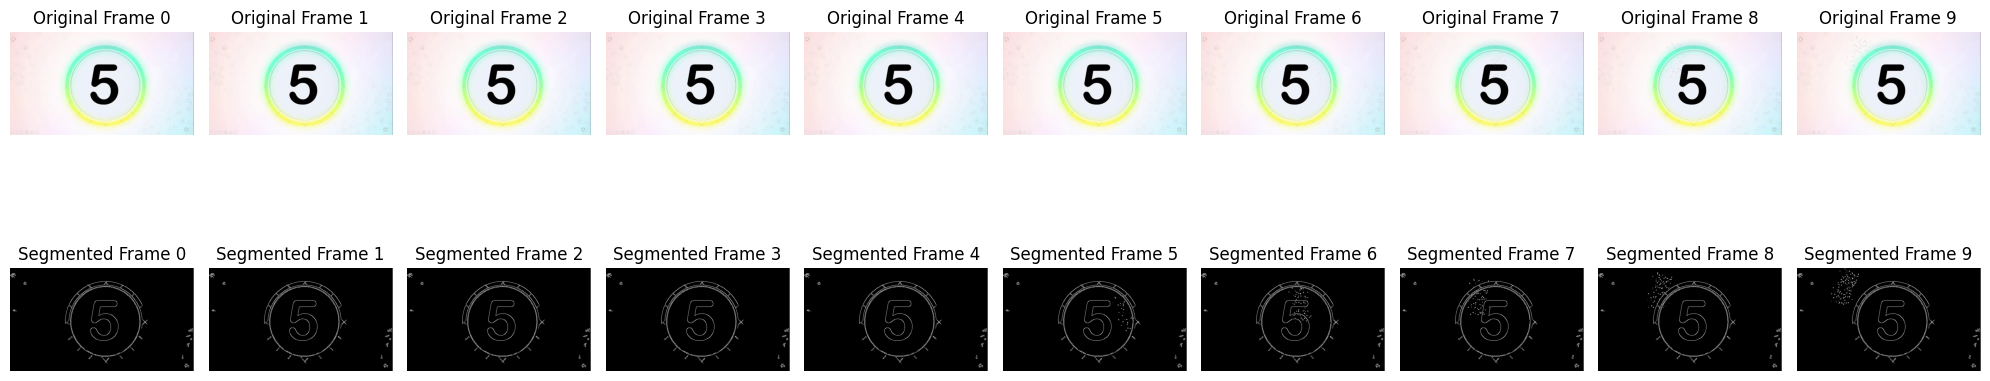

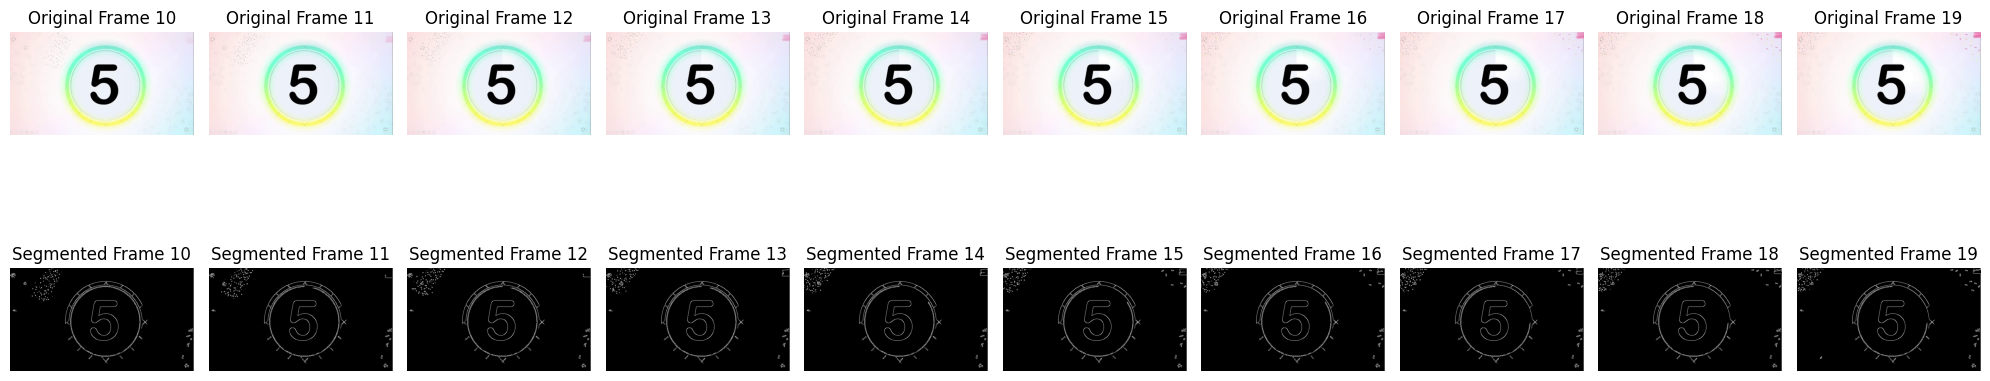

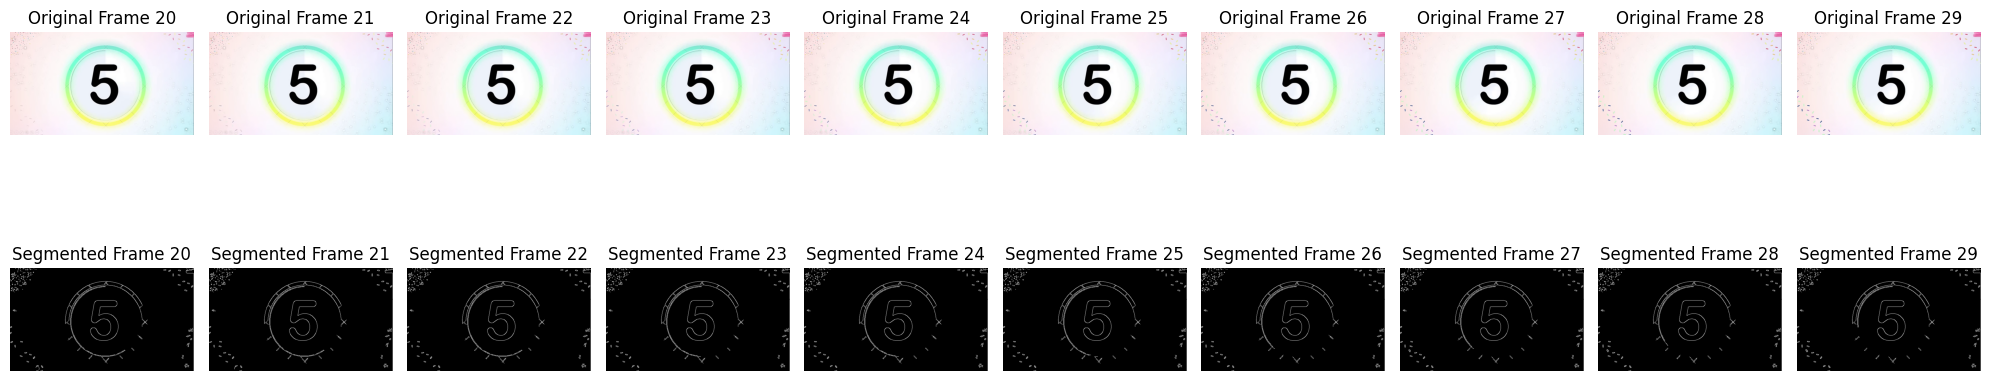

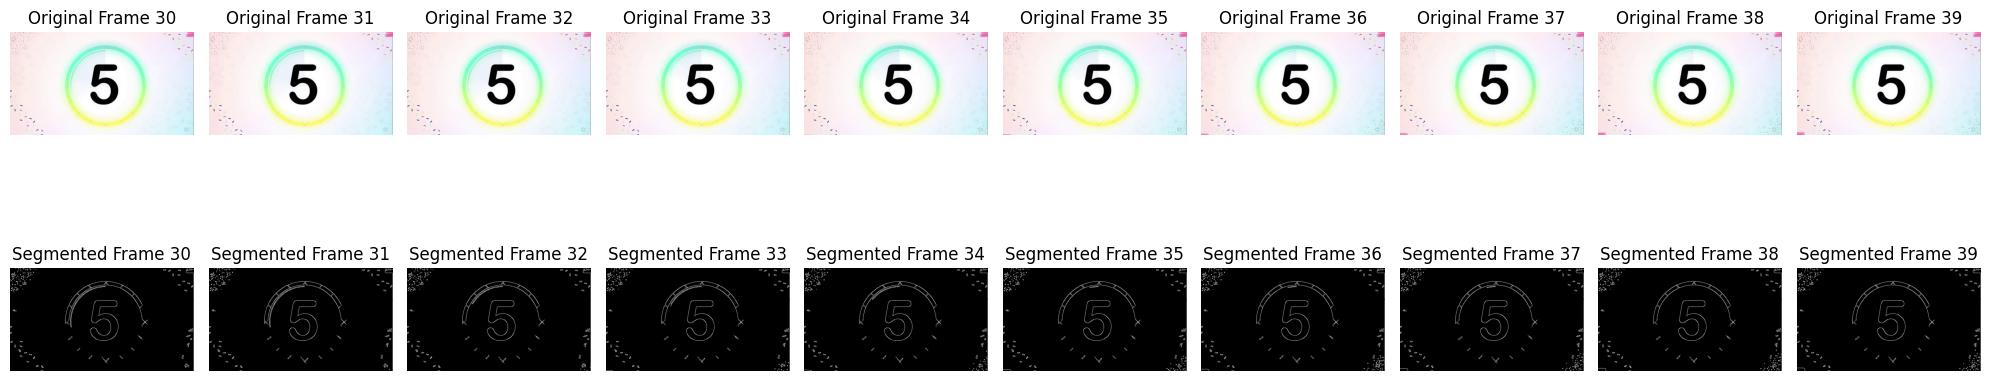

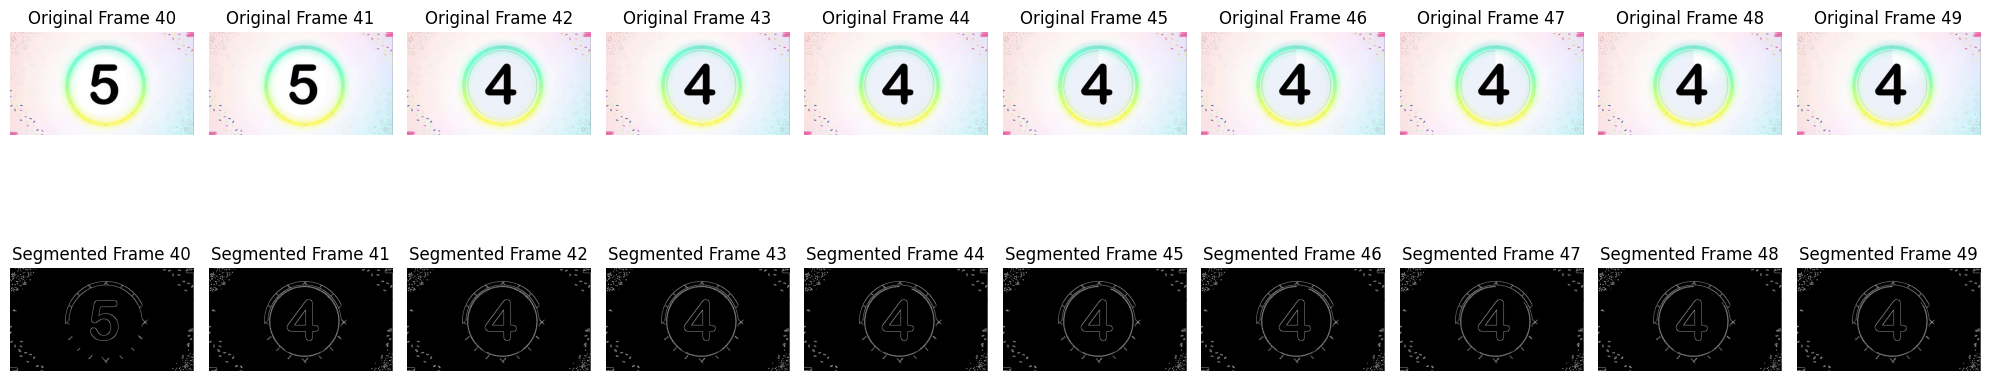

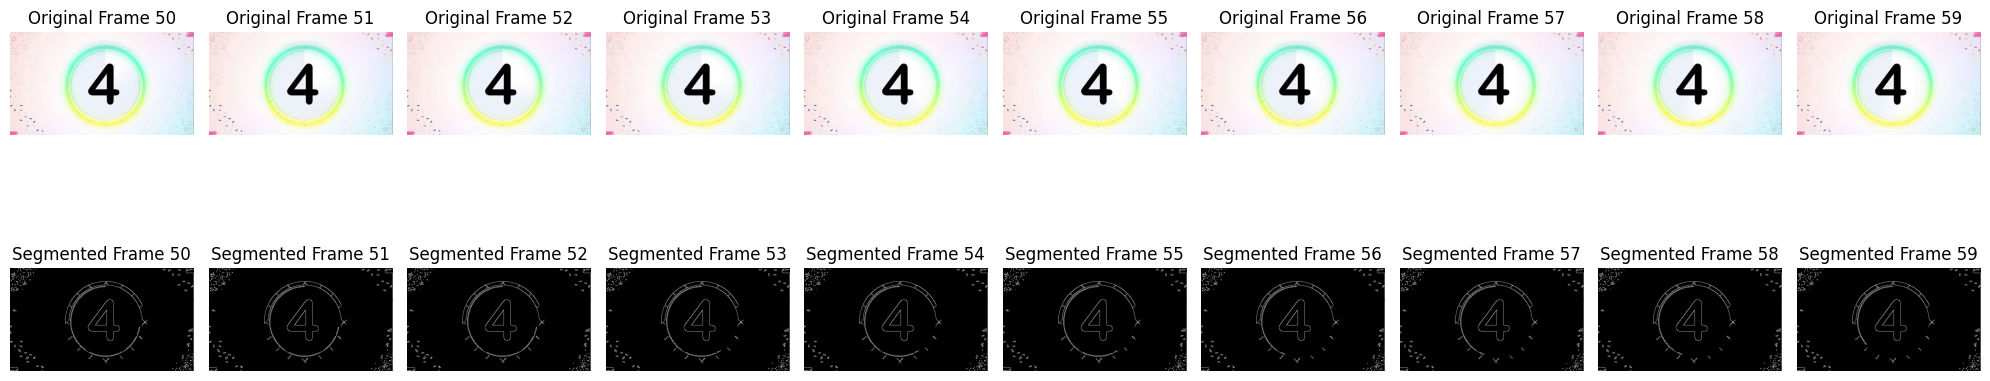

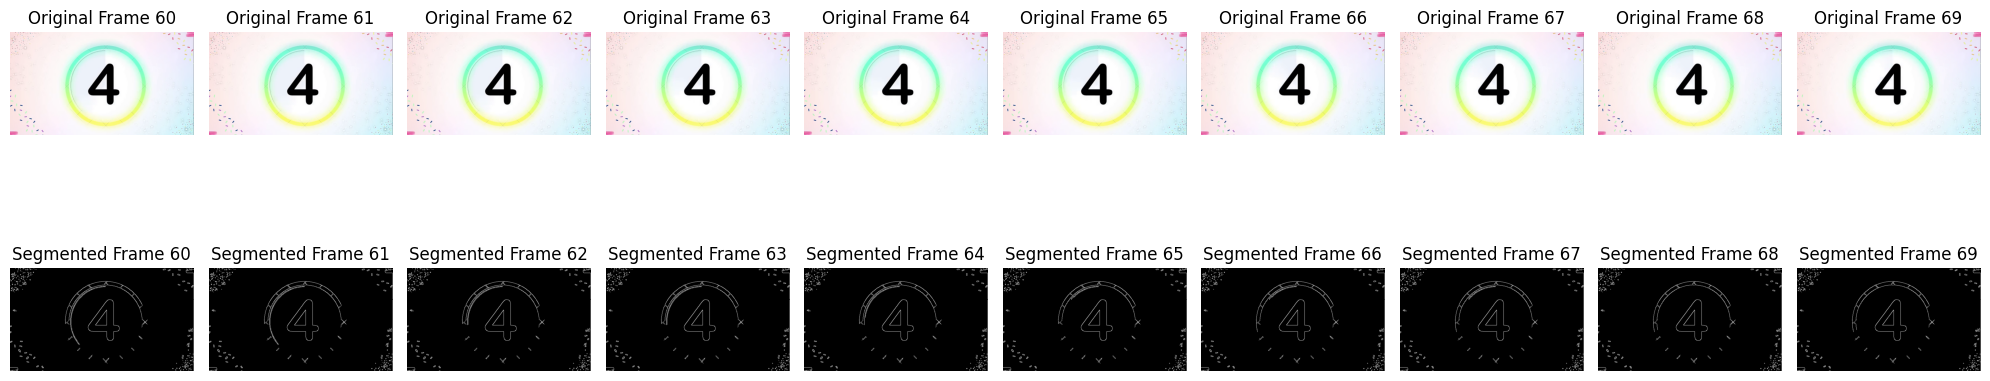

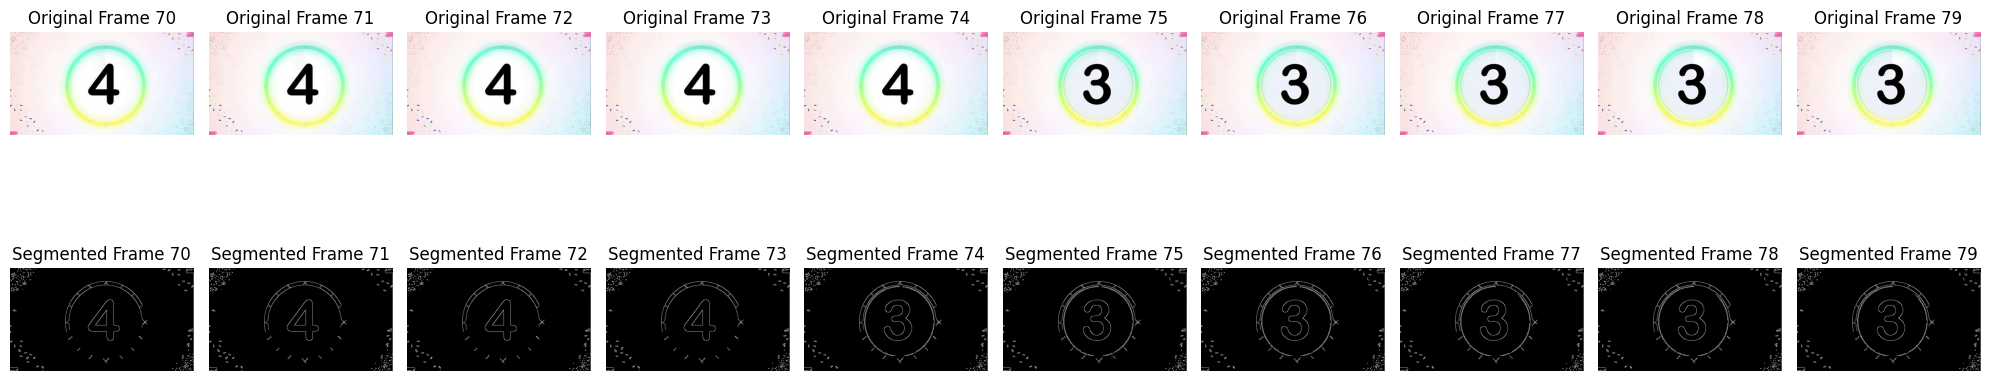

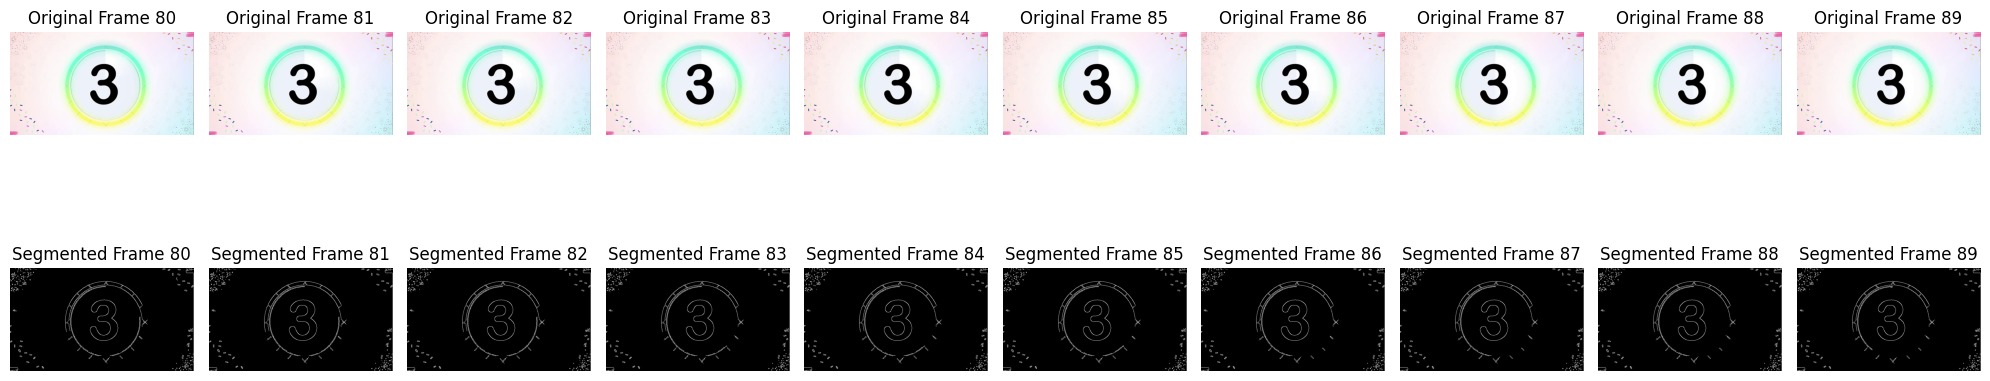

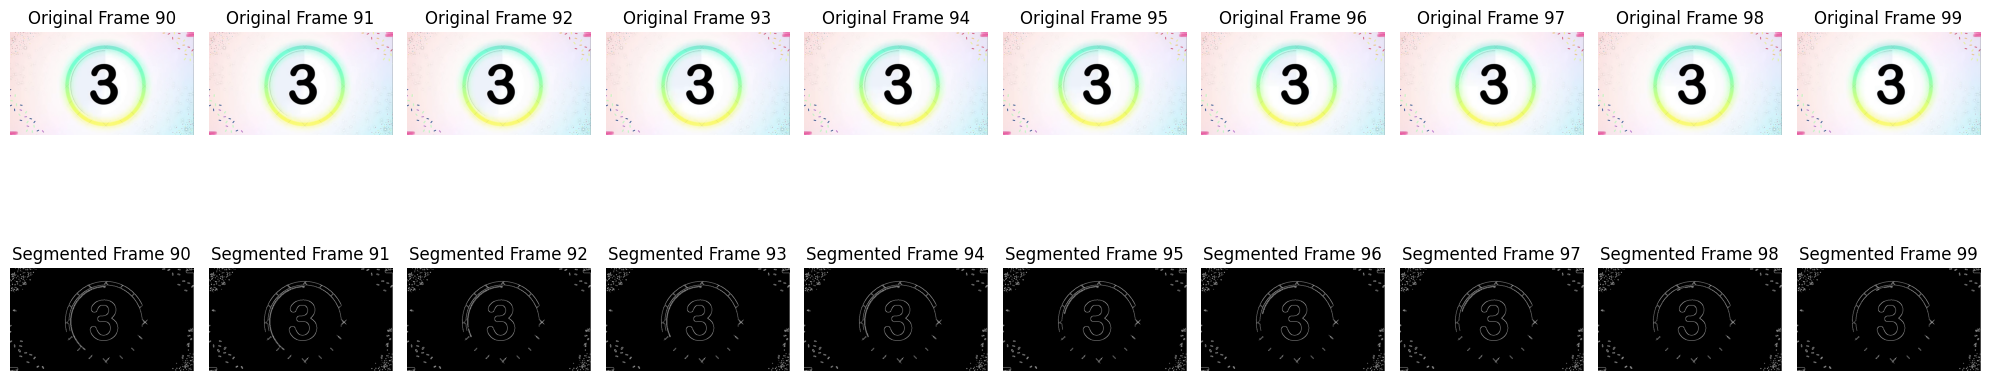

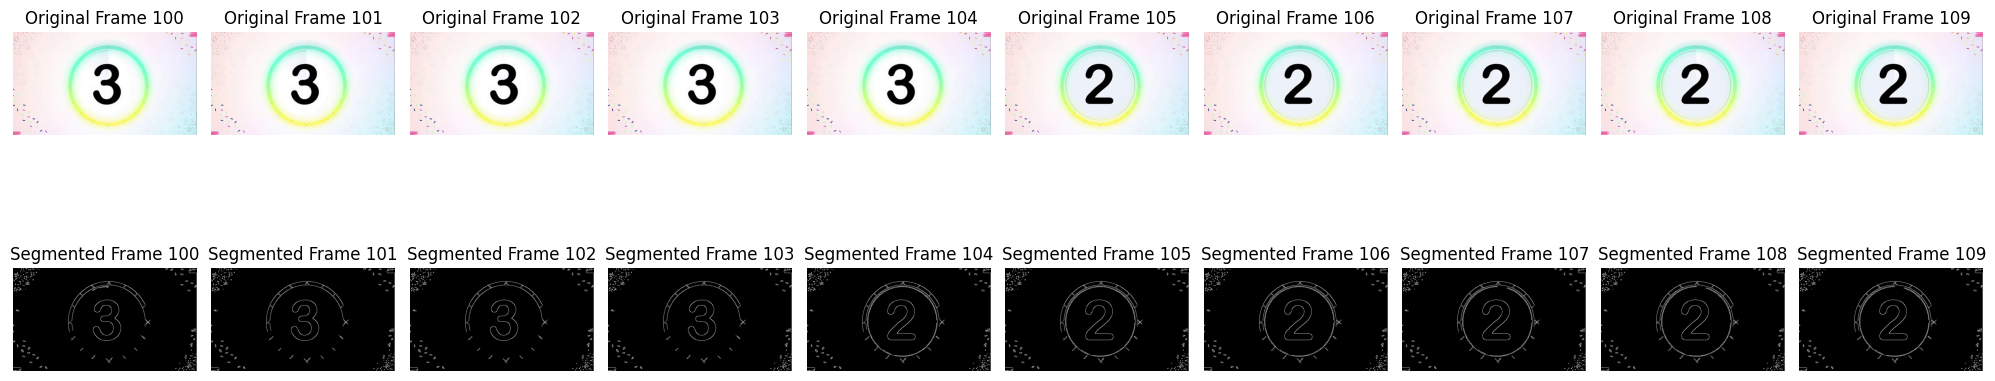

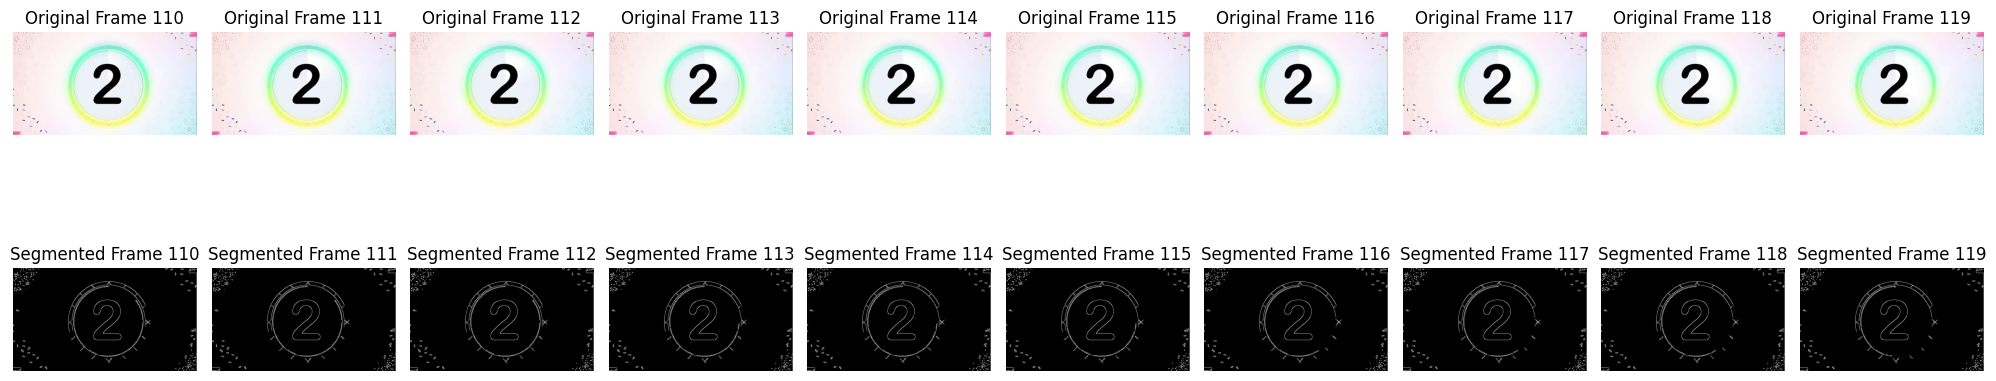

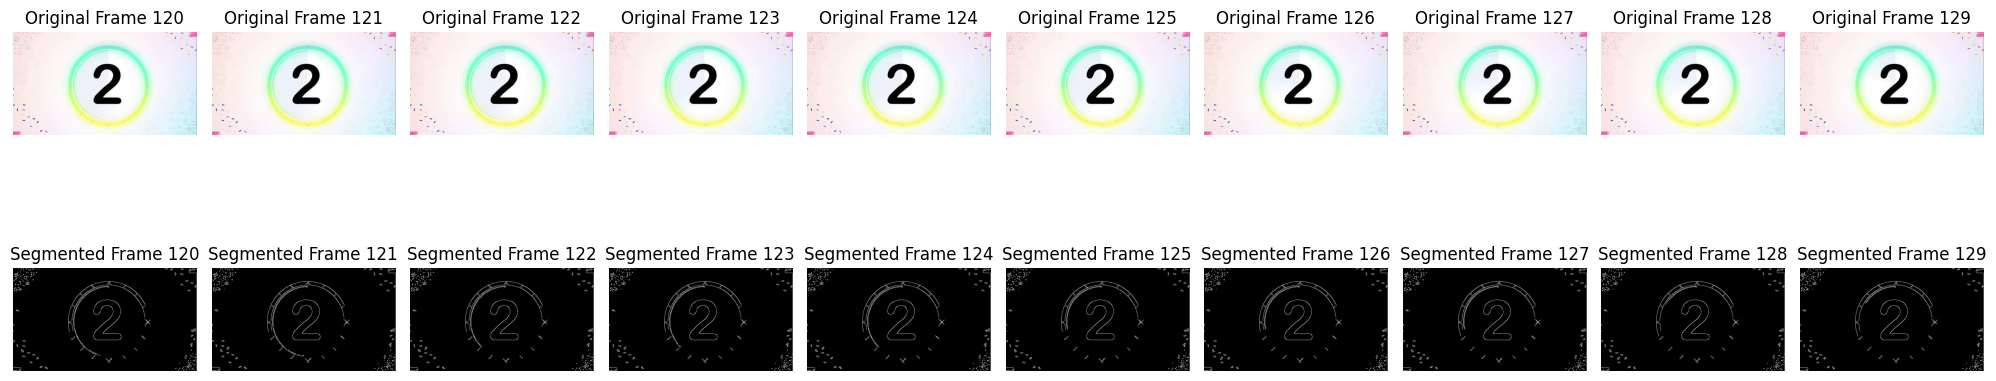

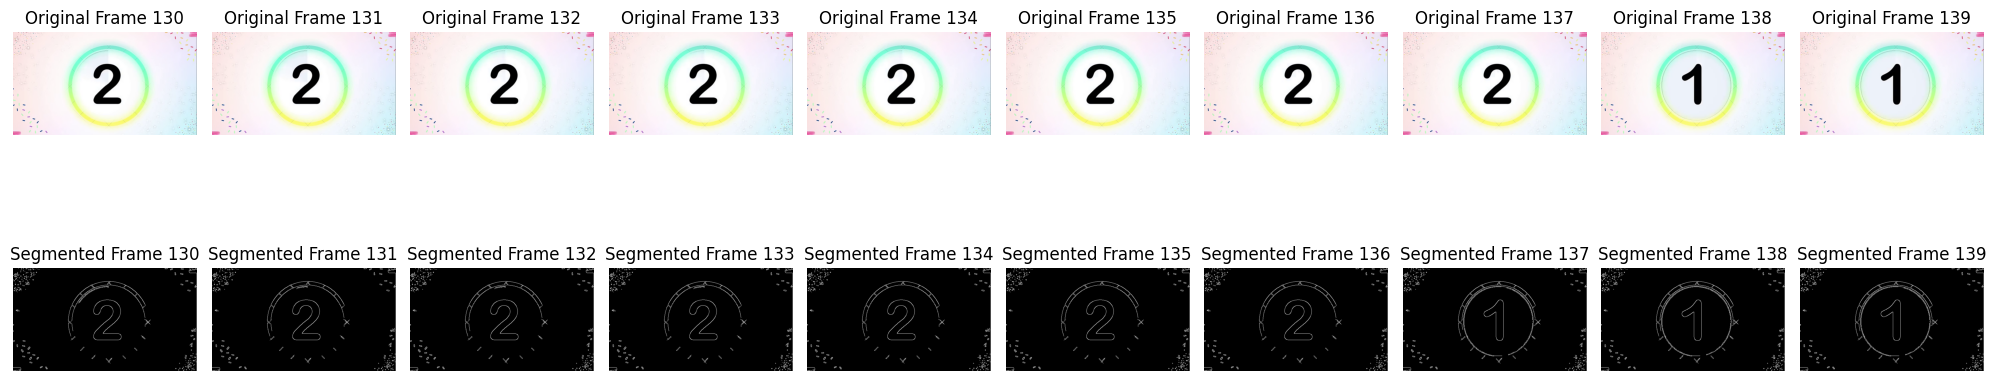

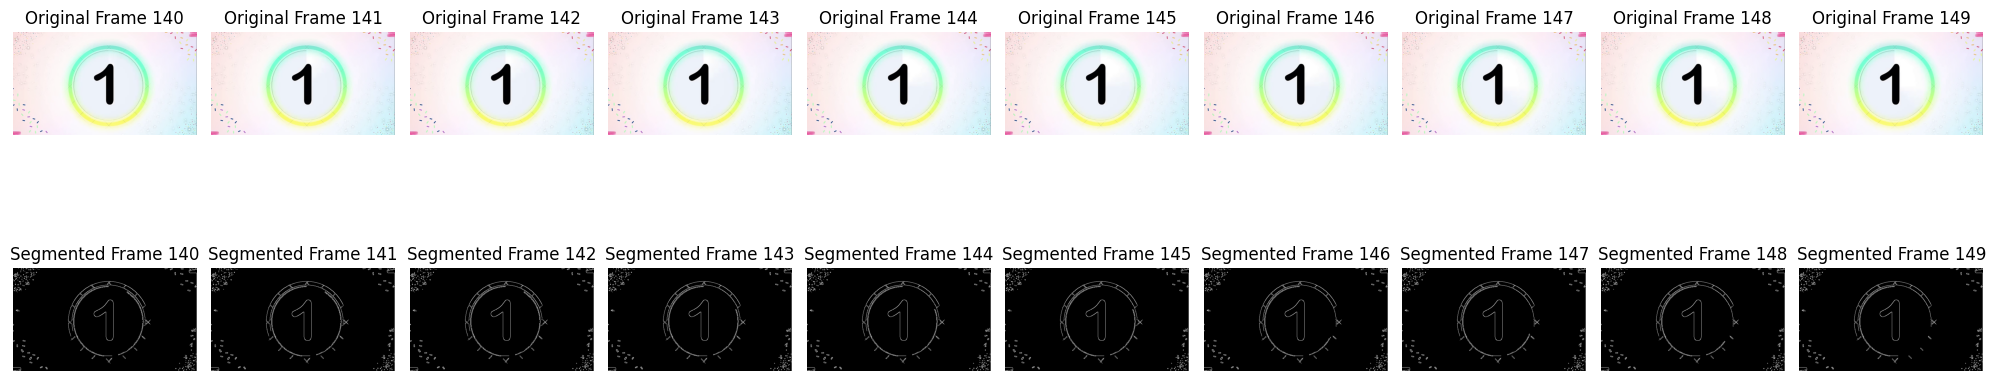

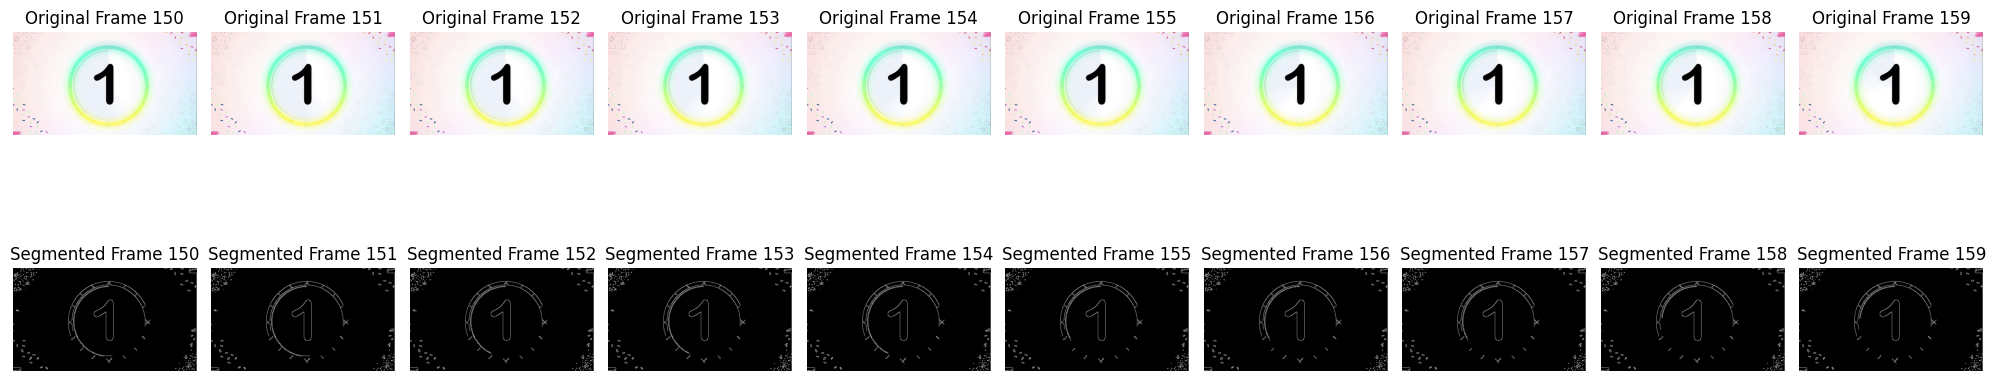

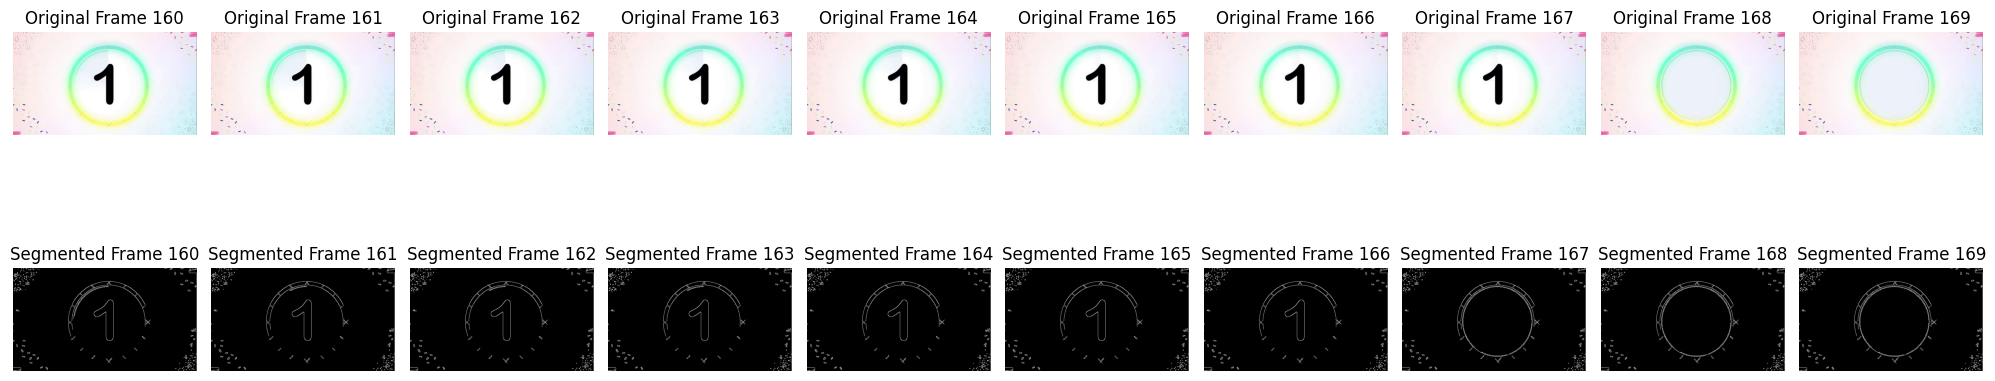

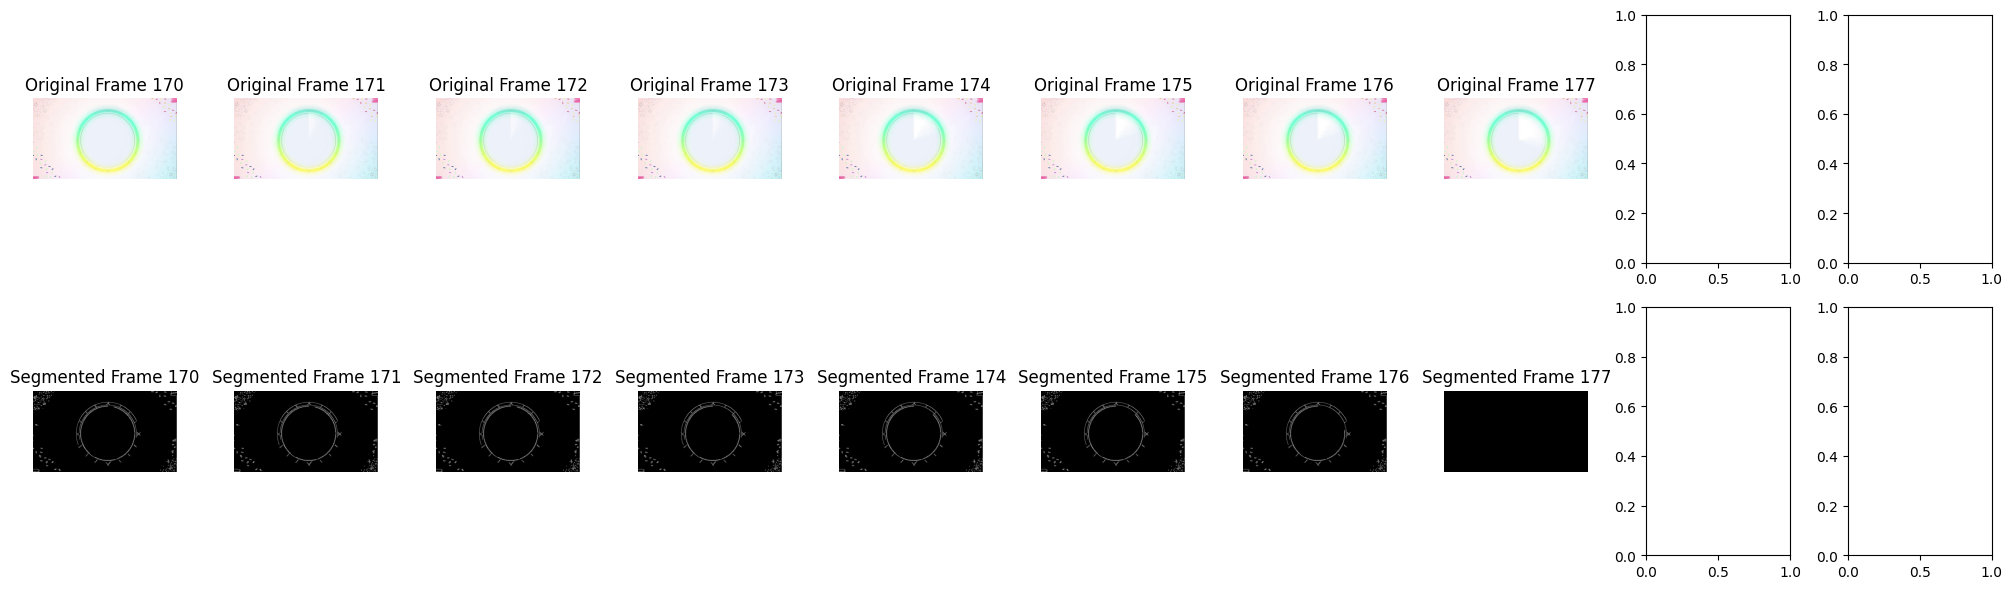

Scene Cuts Summary:
Scene cut detected at frame 12: Hard Cut
Scene cut detected at frame 15: Hard Cut
Scene cut detected at frame 15: Soft Cut
Scene cut detected at frame 18: Hard Cut
Scene cut detected at frame 42: Hard Cut
Scene cut detected at frame 42: Soft Cut
Scene cut detected at frame 75: Hard Cut
Scene cut detected at frame 75: Soft Cut
Scene cut detected at frame 105: Hard Cut
Scene cut detected at frame 105: Soft Cut
Scene cut detected at frame 138: Hard Cut
Scene cut detected at frame 138: Soft Cut
Scene cut detected at frame 144: Soft Cut
Scene cut detected at frame 159: Hard Cut
Scene cut detected at frame 168: Hard Cut
Scene cut detected at frame 168: Soft Cut
Scene cut detected at frame 174: Soft Cut
Scene cut detected at frame 177: Soft Cut


In [35]:
# Step 5: Display Results
def display_original_and_segmented(frames, segmented_frames, scene_cuts, frames_per_row=10):

    total_frames = len(frames)
    rows_needed = (total_frames + frames_per_row - 1) // frames_per_row

    for row in range(rows_needed):
        fig, axs = plt.subplots(2, frames_per_row, figsize=(20, 6))

        for col in range(frames_per_row):
            frame_index = row * frames_per_row + col
            if frame_index >= total_frames:
                break

            # Display the original frame
            axs[0, col].imshow(cv2.cvtColor(frames[frame_index], cv2.COLOR_BGR2RGB))
            axs[0, col].set_title(f"Original Frame {frame_index}")
            axs[0, col].axis("off")

            # Display the segmented frame
            axs[1, col].imshow(segmented_frames[frame_index], cmap='gray')
            axs[1, col].set_title(f"Segmented Frame {frame_index}")
            axs[1, col].axis("off")

        plt.tight_layout()
        plt.show()

    print("Scene Cuts Summary:")
    for cut in scene_cuts:
        print(f"Scene cut detected at frame {cut[0]}: {cut[1]}")

display_original_and_segmented(frames, segmented_frames, scene_cuts, frames_per_row=10)